# `Промышленное машинное обучение на Spark`
## `Задание 03: Spark Details`

<span style="color:red">Дедлайн: 5 марта 2024. 00:00</span>

<span style="color:red">Заполненный ноутбук присылать на почту <b>ekolmagorov98@yandex.ru</b> с темой письма <b>[HSE Spark 2023][Задание 03][ФИО]</b>.</span>

In [1]:
! pip install pyspark pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 33.5 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.7 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.6 MB/s eta 0:00:00


In [7]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 44.3 MB/s eta 0:00:00


In [1]:
import datetime

from typing import List, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '6g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

24/03/02 17:24:07 WARN Utils: Your hostname, vm-03 resolves to a loopback address: 127.0.1.1; using 10.128.0.8 instead (on interface eth0)
24/03/02 17:24:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/02 17:24:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Скачаем и распакуем данные из соревнования [Web Traffic Time Series Forecasting](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/leaderboard).


In [3]:
import json
import requests
import subprocess
import zipfile

folder_url = 'https://disk.yandex.ru/d/v2DatluRGmU2Ng'
file_url = '/web_traffic_data_v2.csv.zip'
# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url}) 
# 'парсинг' ссылки на скачивание
data_link = response.json()['href'] 	

filename = 'web_traffic_data.csv.zip'
# путь куда распакуются данные
path = "./web_traffic_data.csv"

# запускаем скачивание вызовом команды wget из python
subprocess.run(
    ['wget', '-O', filename, data_link], # команда для исполнения
    stdout=subprocess.DEVNULL, # убираем печать отладочной информации
    stderr=subprocess.STDOUT
)

CompletedProcess(args=['wget', '-O', 'web_traffic_data.csv.zip', 'https://downloader.disk.yandex.ru/disk/e2b9241f8ab3427e3642df0888bcde197176307b02b2c98bca768dbe154cfc01/65e0993b/qo_oUU0UNiEpD-z6-zCIgT_3WffF4HNqJJJq_FMtn5WaEY0cM_1uUCfDatV7tgv7rdx08p1BkaBAc6gEcYOliQ%3D%3D?uid=0&filename=web_traffic_data_v2.csv.zip&disposition=attachment&hash=E49MtubvUrb12FBU2QEZgwKTWY0nBRgBDJOGkLQys5mIjn242W1EcdqTcysdGxI5q/J6bpmRyOJonT3VoXnDag%3D%3D%3A/web_traffic_data_v2.csv.zip&limit=0&content_type=application%2Fzip&owner_uid=1199758960&fsize=37763121&hid=87218715b9182af504ddba78af588dcf&media_type=compressed&tknv=v2'], returncode=0)

Произведём распаковку таблицы

In [4]:
! unzip web_traffic_data.csv.zip 

# тк все данные уже распакованы, то удалим ненужные далее архивы с данными
! rm -rf web_traffic_data.csv.zip

Archive:  web_traffic_data.csv.zip
replace web_traffic_data_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Загрузим информацию о просмотрах страниц Википедии по дням в виде DataFrame:

In [2]:
# Сконструируем схему DataFrame в явном виде
# Это необходимо для более простого заполнения пропусков
#   так по умолчанию все колонки с пропусками определяются
#   как строковые
schema = T.StructType()
schema.add('Page', T.StringType())

delta = datetime.timedelta(days=1)
date = datetime.date.fromisoformat('2015-07-01')
for _ in range(803):
    schema.add(date.isoformat(), T.FloatType())
    date += delta

df = (
    spark.read.format('csv')
        .option('header', True)
        .option('sep', ',')
        .schema(schema)
        .load('./web_traffic_data_v2.csv')
        .fillna(0.0)
)

df.limit(5).toPandas()

24/03/02 17:24:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,Idioma_español_es.wikipedia.org_all-access_spider,99.0,116.0,70.0,63.0,59.0,79.0,54.0,83.0,72.0,...,227.0,304.0,93.0,255.0,101.0,255.0,567.0,106.0,129.0,52.0
1,張藝興_zh.wikipedia.org_mobile-web_all-agents,306.0,305.0,261.0,466.0,441.0,343.0,390.0,299.0,292.0,...,529.0,756.0,758.0,691.0,821.0,631.0,643.0,591.0,784.0,1035.0
2,Special:WhatLinksHere_commons.wikimedia.org_al...,21.0,33.0,42.0,37.0,36.0,70.0,42.0,31.0,24.0,...,22.0,769.0,458.0,101.0,44.0,542.0,817.0,44.0,792.0,165.0
3,The_Hardkiss_ru.wikipedia.org_all-access_spider,10.0,1.0,2.0,3.0,7.0,4.0,3.0,5.0,3.0,...,3.0,10.0,3.0,2.0,6.0,5.0,5.0,3.0,7.0,4.0
4,金世正_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,19.0,26.0,13.0,7.0,19.0,14.0,15.0,12.0,3.0


***Замечание:*** Используйте метод `cache` для сохранения промежуточных результатов, которые Вы планируете переиспользовать!

**Задание 01:** Разбейте колонку `Page` в соответствии со схемой в описании данных (`name_project_access_agent`). В результате нужно составить DataFrame из $5$ колонок: `Page`, `Name`, `Project`, `Access`, `Agent`.

*Замечание 0*: Не используйте UDF.

*Замечание 1*: Название страницы (`Name`) может содержать любое количество символов `_`.

*Замечание 2*: Некоторые строки "обёрнуты" в двойные кавычки. Желательно первой трансформацией над колонкой `Page` из всех таких строк убрать лишние внешние кавычки.

*Замечание 3:* Строки, которые не удовлетворяют указанному паттерну, нужно выделить в отдельный DataFrame.

*Замечание 4:* Для удобства, используйте возможность сохранения колоночных выражений в переменные.

*Подсказка 1:* Подстроки переменной длины можно выделять [следующим образом](https://stackoverflow.com/questions/53153149/remove-last-few-characters-in-pyspark-dataframe-column).

*Подсказка 2:* Данную задачу можно решать разными вариантами кода, функции которые могут быть полезны для неё: `.when().otherwise()`, `substring`, `size`, `expr`, `split`, `array_join`, `slice`, `element_at`.

Посмотрим какие строки обёрнуты в двойные кавычки

In [3]:
# YOUR CODE HERE
# смотрим все что обернуто в двойные кавычки
df.filter(df['Page'].like('\"%\"')).select('Page').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+
|Page                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------+
|"File:It's_said_that_Colby's_Pincher_was_""The_greatest_fighting_dog_that_ever_lived"".jpg_commons.wikimedia.org_mobile-web_all-agents"         |
|"File:Bundesarchiv_Bild_101I-022-2948-19,_Russland,_Unternehmen_""Zitadelle""._Soldatengrab.jpg_commons.wikimedia.org_desktop_all-agents"       |
|"""Heroes""_(David_Bowie_album)_en.wikipedia.org_desktop_all-agents"                                                                            |
|"Eddie_""The_Eagle""_Edwards_en.wikipedia.org_desktop_all-agents"                                                    

Теперь попробуем убрать внешние двойные кавычки

In [4]:
# YOUR CODE HERE
# Удаляем обертку из кавычек

df = df.withColumn('Page', 
                       F.when(F.col('Page').startswith('"') & F.col('Page').endswith('"'), 
                            F.col('Page').substr(1, len('Page') - 2)).otherwise(F.col('Page')))

# смотрим что осталось
df.filter(df['Page'].like('\"%\"')).select('Page').show(5, False)

+----+
|Page|
+----+
|""  |
|""  |
+----+



Теперь разобьём колонку Page.

In [5]:
### YOUR CODE HERE:
# разбиваем на части
page_parts = F.split(F.col('Page'), '_')

# найдем число частей
parts_num = F.size(page_parts)

# все кроме 3-х последних частей джойним через символ _ в часть с названием name
name_part = F.array_join(F.slice(page_parts, 1, parts_num - 3), '_')

# 3я часть с конца - это project
project_part = F.element_at(page_parts, -3)

# 2я часть с конца - это access
access_part = F.element_at(page_parts, -2)

# 1я часть с конца - это agent
agent_part = F.element_at(page_parts, -1)

# если всего частей строго больше 3х, то это фрейм articles
articles = df.withColumn('Name', name_part) \
               .withColumn('Project', project_part) \
               .withColumn('Access', access_part) \
               .withColumn('Agent', agent_part) \
               .where(parts_num > 3).cache()

# если нет, то фрейм currupted
corrupted_articles = df.where(parts_num <= 3)

# взглянем на articles
articles.limit(5).toPandas()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,Name,Project,Access,Agent
0,Idioma_español_es.wikipedia.org_all-access_spider,99.0,116.0,70.0,63.0,59.0,79.0,54.0,83.0,72.0,...,101.0,255.0,567.0,106.0,129.0,52.0,Idioma_español,es.wikipedia.org,all-access,spider
1,張藝興_zh.wikipedia.org_mobile-web_all-agents,306.0,305.0,261.0,466.0,441.0,343.0,390.0,299.0,292.0,...,821.0,631.0,643.0,591.0,784.0,1035.0,張藝興,zh.wikipedia.org,mobile-web,all-agents
2,Special:WhatLinksHere_commons.wikimedia.org_al...,21.0,33.0,42.0,37.0,36.0,70.0,42.0,31.0,24.0,...,44.0,542.0,817.0,44.0,792.0,165.0,Special:WhatLinksHere,commons.wikimedia.org,all-access,spider
3,The_Hardkiss_ru.wikipedia.org_all-access_spider,10.0,1.0,2.0,3.0,7.0,4.0,3.0,5.0,3.0,...,6.0,5.0,5.0,3.0,7.0,4.0,The_Hardkiss,ru.wikipedia.org,all-access,spider
4,金世正_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,19.0,14.0,15.0,12.0,3.0,金世正,zh.wikipedia.org,all-access,spider


Проверьте, что предобработка выполнена верно:

In [6]:
corrupted_articles.select("Page").show(truncate=False)

+---------+
|Page     |
+---------+
|"""Awaken|
|"F       |
|"F       |
|""       |
|"E       |
|"E       |
|"F       |
|"F       |
|"E       |
|""       |
+---------+



In [7]:
articles.groupBy('Project').count().show(truncate=False)
articles.groupBy('Access').count().show(truncate=False)
articles.groupBy('Agent').count().show(truncate=False)

+---------------------+-----+
|Project              |count|
+---------------------+-----+
|commons.wikimedia.org|2251 |
|en.wikipedia.org     |5068 |
|www.mediawiki.org    |1525 |
|de.wikipedia.org     |3734 |
|es.wikipedia.org     |2846 |
|ja.wikipedia.org     |4236 |
|ru.wikipedia.org     |3131 |
|zh.wikipedia.org     |3573 |
|fr.wikipedia.org     |3626 |
+---------------------+-----+

+----------+-----+
|Access    |count|
+----------+-----+
|desktop   |7228 |
|all-access|15314|
|mobile-web|7448 |
+----------+-----+

+----------+-----+
|Agent     |count|
+----------+-----+
|all-agents|22737|
|spider    |7253 |
+----------+-----+



**Задание 02:** Выполните unpivot исходных данных.

*Замечание 1*: Выражение для unpivot нужно сконструировать циклом по всем колонкам с датами.

*Замечание 2*: В колоночных строковых выражениях можно указывать колонки с произвольным названием при использовании экранирования. Например: ``` `2015-07-01` ```. Так как иначе формат даты ```2015-07-01``` будет интерпретироваться как математическое выражение.  

In [8]:
# YOUR CODE HERE
date = datetime.date.fromisoformat('2015-07-01')
delta = datetime.timedelta(days=1)
cols = ['2015-07-01'] + [(date := date + delta).isoformat() for _ in range(802)]
df_unpivot = df.unpivot('Page', cols, 'Day', 'Views' ).cache()
df_unpivot.show()

+--------------------+----------+-----+
|                Page|       Day|Views|
+--------------------+----------+-----+
|Idioma_español_es...|2015-07-01| 99.0|
|Idioma_español_es...|2015-07-02|116.0|
|Idioma_español_es...|2015-07-03| 70.0|
|Idioma_español_es...|2015-07-04| 63.0|
|Idioma_español_es...|2015-07-05| 59.0|
|Idioma_español_es...|2015-07-06| 79.0|
|Idioma_español_es...|2015-07-07| 54.0|
|Idioma_español_es...|2015-07-08| 83.0|
|Idioma_español_es...|2015-07-09| 72.0|
|Idioma_español_es...|2015-07-10| 77.0|
|Idioma_español_es...|2015-07-11| 78.0|
|Idioma_español_es...|2015-07-12| 77.0|
|Idioma_español_es...|2015-07-13|138.0|
|Idioma_español_es...|2015-07-14|128.0|
|Idioma_español_es...|2015-07-15|107.0|
|Idioma_español_es...|2015-07-16|136.0|
|Idioma_español_es...|2015-07-17|181.0|
|Idioma_español_es...|2015-07-18| 85.0|
|Idioma_español_es...|2015-07-19|106.0|
|Idioma_español_es...|2015-07-20|108.0|
+--------------------+----------+-----+
only showing top 20 rows



**Задание 03:** Для каждой записи в данных посчитайте среднее число просмотров за предыдущие $14$ дней.

*Замечание 1*: Используйте оконные функции.

*Замечание 2*: Для работы с датами можно использовать функцию `cast` для преобразования строки в timestamp.

*Замечание 3*: Проанализируйте [ответы `ZygD` и `zero323`](https://stackoverflow.com/questions/33207164/spark-window-functions-rangebetween-dates).

In [9]:
### YOUR CODE HERE:
days = lambda i: i * 86400
w = (Window()
        .partitionBy(F.col('Page'))
        .orderBy(F.col('Day').cast('timestamp').cast('long'))
        .rangeBetween(-days(14), 0)
    )

df_unpivot = df_unpivot.withColumn('Mean Views', F.mean('Views').over(w)).cache()
df_unpivot.where(F.col('Page').like('Idioma_español_es%')).show(10)

+--------------------+----------+------+------------------+
|                Page|       Day| Views|        Mean Views|
+--------------------+----------+------+------------------+
|Idioma_español_es...|2015-07-01|1321.0|            1321.0|
|Idioma_español_es...|2015-07-02|1218.0|            1269.5|
|Idioma_español_es...|2015-07-03|1129.0|1222.6666666666667|
|Idioma_español_es...|2015-07-04|1187.0|           1213.75|
|Idioma_español_es...|2015-07-05|1325.0|            1236.0|
|Idioma_español_es...|2015-07-06|1319.0|1249.8333333333333|
|Idioma_español_es...|2015-07-07|1356.0|            1265.0|
|Idioma_español_es...|2015-07-08|1402.0|          1282.125|
|Idioma_español_es...|2015-07-09|1382.0|1293.2222222222222|
|Idioma_español_es...|2015-07-10|1264.0|            1290.3|
+--------------------+----------+------+------------------+
only showing top 10 rows



**Задание 04:** По исходным данным посчитайте суммарное число просмотров за все дни. Отсортируйте страницы по убыванию числа просмотров.
    
*Замечание*: Используйте RDD API.

In [10]:
### YOUR CODE HERE:
views = (
        df_unpivot
         .groupBy('Page')
         .agg(F.sum('Views').alias('TotalViews'))
         .sort('TotalViews', ascending=False)
        )

In [11]:
most_viewed = views.take(10)
most_viewed

[Row(Page='Main_Page_en.wikipedia.org_mobile-web_all-agents', TotalViews=3838848757.0),
 Row(Page='Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', TotalViews=2267327557.0),
 Row(Page='Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', TotalViews=958693538.0),
 Row(Page='Spezial:Suche_de.wikipedia.org_desktop_all-agents', TotalViews=305565356.0),
 Row(Page='Special:Book_en.wikipedia.org_desktop_all-agents', TotalViews=216175504.0),
 Row(Page='Sp?cial:Search_fr.wikipedia.org_desktop_all-agents', TotalViews=130453754.0),
 Row(Page='XHamster_en.wikipedia.org_mobile-web_all-agents', TotalViews=121623395.0),
 Row(Page='Special:CreateAccount_commons.wikimedia.org_desktop_all-agents', TotalViews=109114961.0),
 Row(Page='Especial:Buscar_es.wikipedia.org_mobile-web_all-agents', TotalViews=99640828.0),
 Row(Page='Special:搜索_zh.wikipedia.org_desktop_all-agents', TotalViews=66987851.0)]

**Задание 05:** Возьмите страницу с самым большим числом просмотром. Изобразите на одном графике динамику просмотров и средних просмотров за $14$ дней по дням.

In [12]:
most_viewed_page_name = most_viewed[0][0]
most_viewed_page_name

'Main_Page_en.wikipedia.org_mobile-web_all-agents'

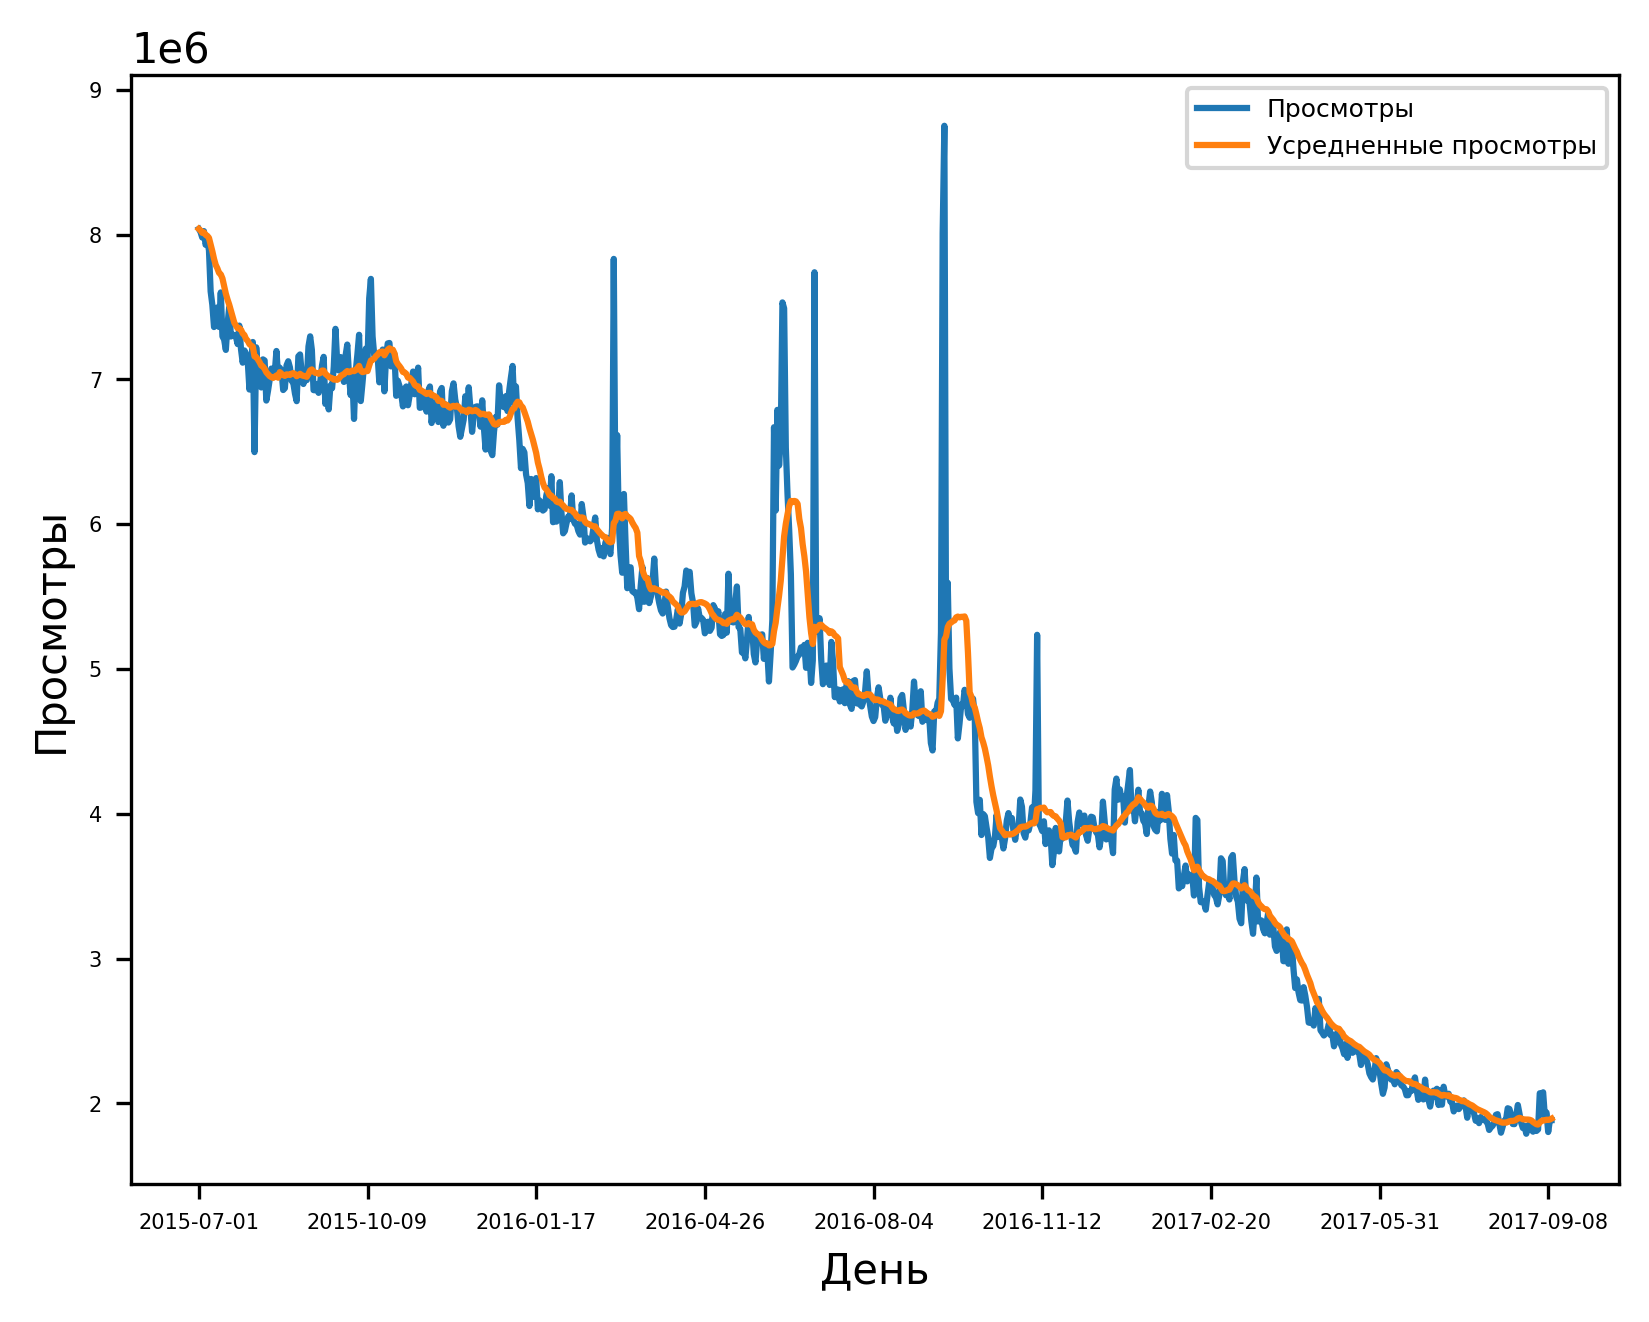

In [13]:
# YOUR CODE HERE
(
    df_unpivot
    .where(F.col('Page') == most_viewed_page_name)
    .toPandas()
    .plot('Day', 
          ['Views', 'Mean Views'], 
          xlabel='День',
          ylabel='Просмотры',
          label=['Просмотры', 'Усредненные просмотры'],
          fontsize=5).legend(loc='upper right', fontsize=6)
);

**Задание 06:** Используя информацию из DataFrame `articles`, посчитайте для каждой записи в разрезе Project/Access максимальное число просмотров за все предшествующие дни.

In [14]:
art_unpivot = (articles
                   .unpivot(['Page', 'Project', 'Access'], cols, 'Day', 'Views' )
                   .groupBy('Project', 'Access', 'Day')
                   .agg(F.sum("Views").alias("Views"))
              )

In [15]:
w = Window.partitionBy("Project", "Access").orderBy("Day").rowsBetween(Window.unboundedPreceding, -1)
art_maxv = art_unpivot.withColumn("MaxPreviousViews", F.max("Views").over(w))
art_maxv.show()

+--------------------+----------+----------+--------+----------------+
|             Project|    Access|       Day|   Views|MaxPreviousViews|
+--------------------+----------+----------+--------+----------------+
|commons.wikimedia...|all-access|2015-07-01| 72371.0|            NULL|
|commons.wikimedia...|all-access|2015-07-02| 78718.0|         72371.0|
|commons.wikimedia...|all-access|2015-07-03| 84049.0|         78718.0|
|commons.wikimedia...|all-access|2015-07-04| 70962.0|         84049.0|
|commons.wikimedia...|all-access|2015-07-05| 70410.0|         84049.0|
|commons.wikimedia...|all-access|2015-07-06| 79011.0|         84049.0|
|commons.wikimedia...|all-access|2015-07-07|111524.0|         84049.0|
|commons.wikimedia...|all-access|2015-07-08|105269.0|        111524.0|
|commons.wikimedia...|all-access|2015-07-09| 97772.0|        111524.0|
|commons.wikimedia...|all-access|2015-07-10| 78423.0|        111524.0|
|commons.wikimedia...|all-access|2015-07-11| 68009.0|        111524.0|
|commo

**Задание 07:** Изобразите динамику максимального числа просмотров за предшествующие дни в разрезе Project/Access.

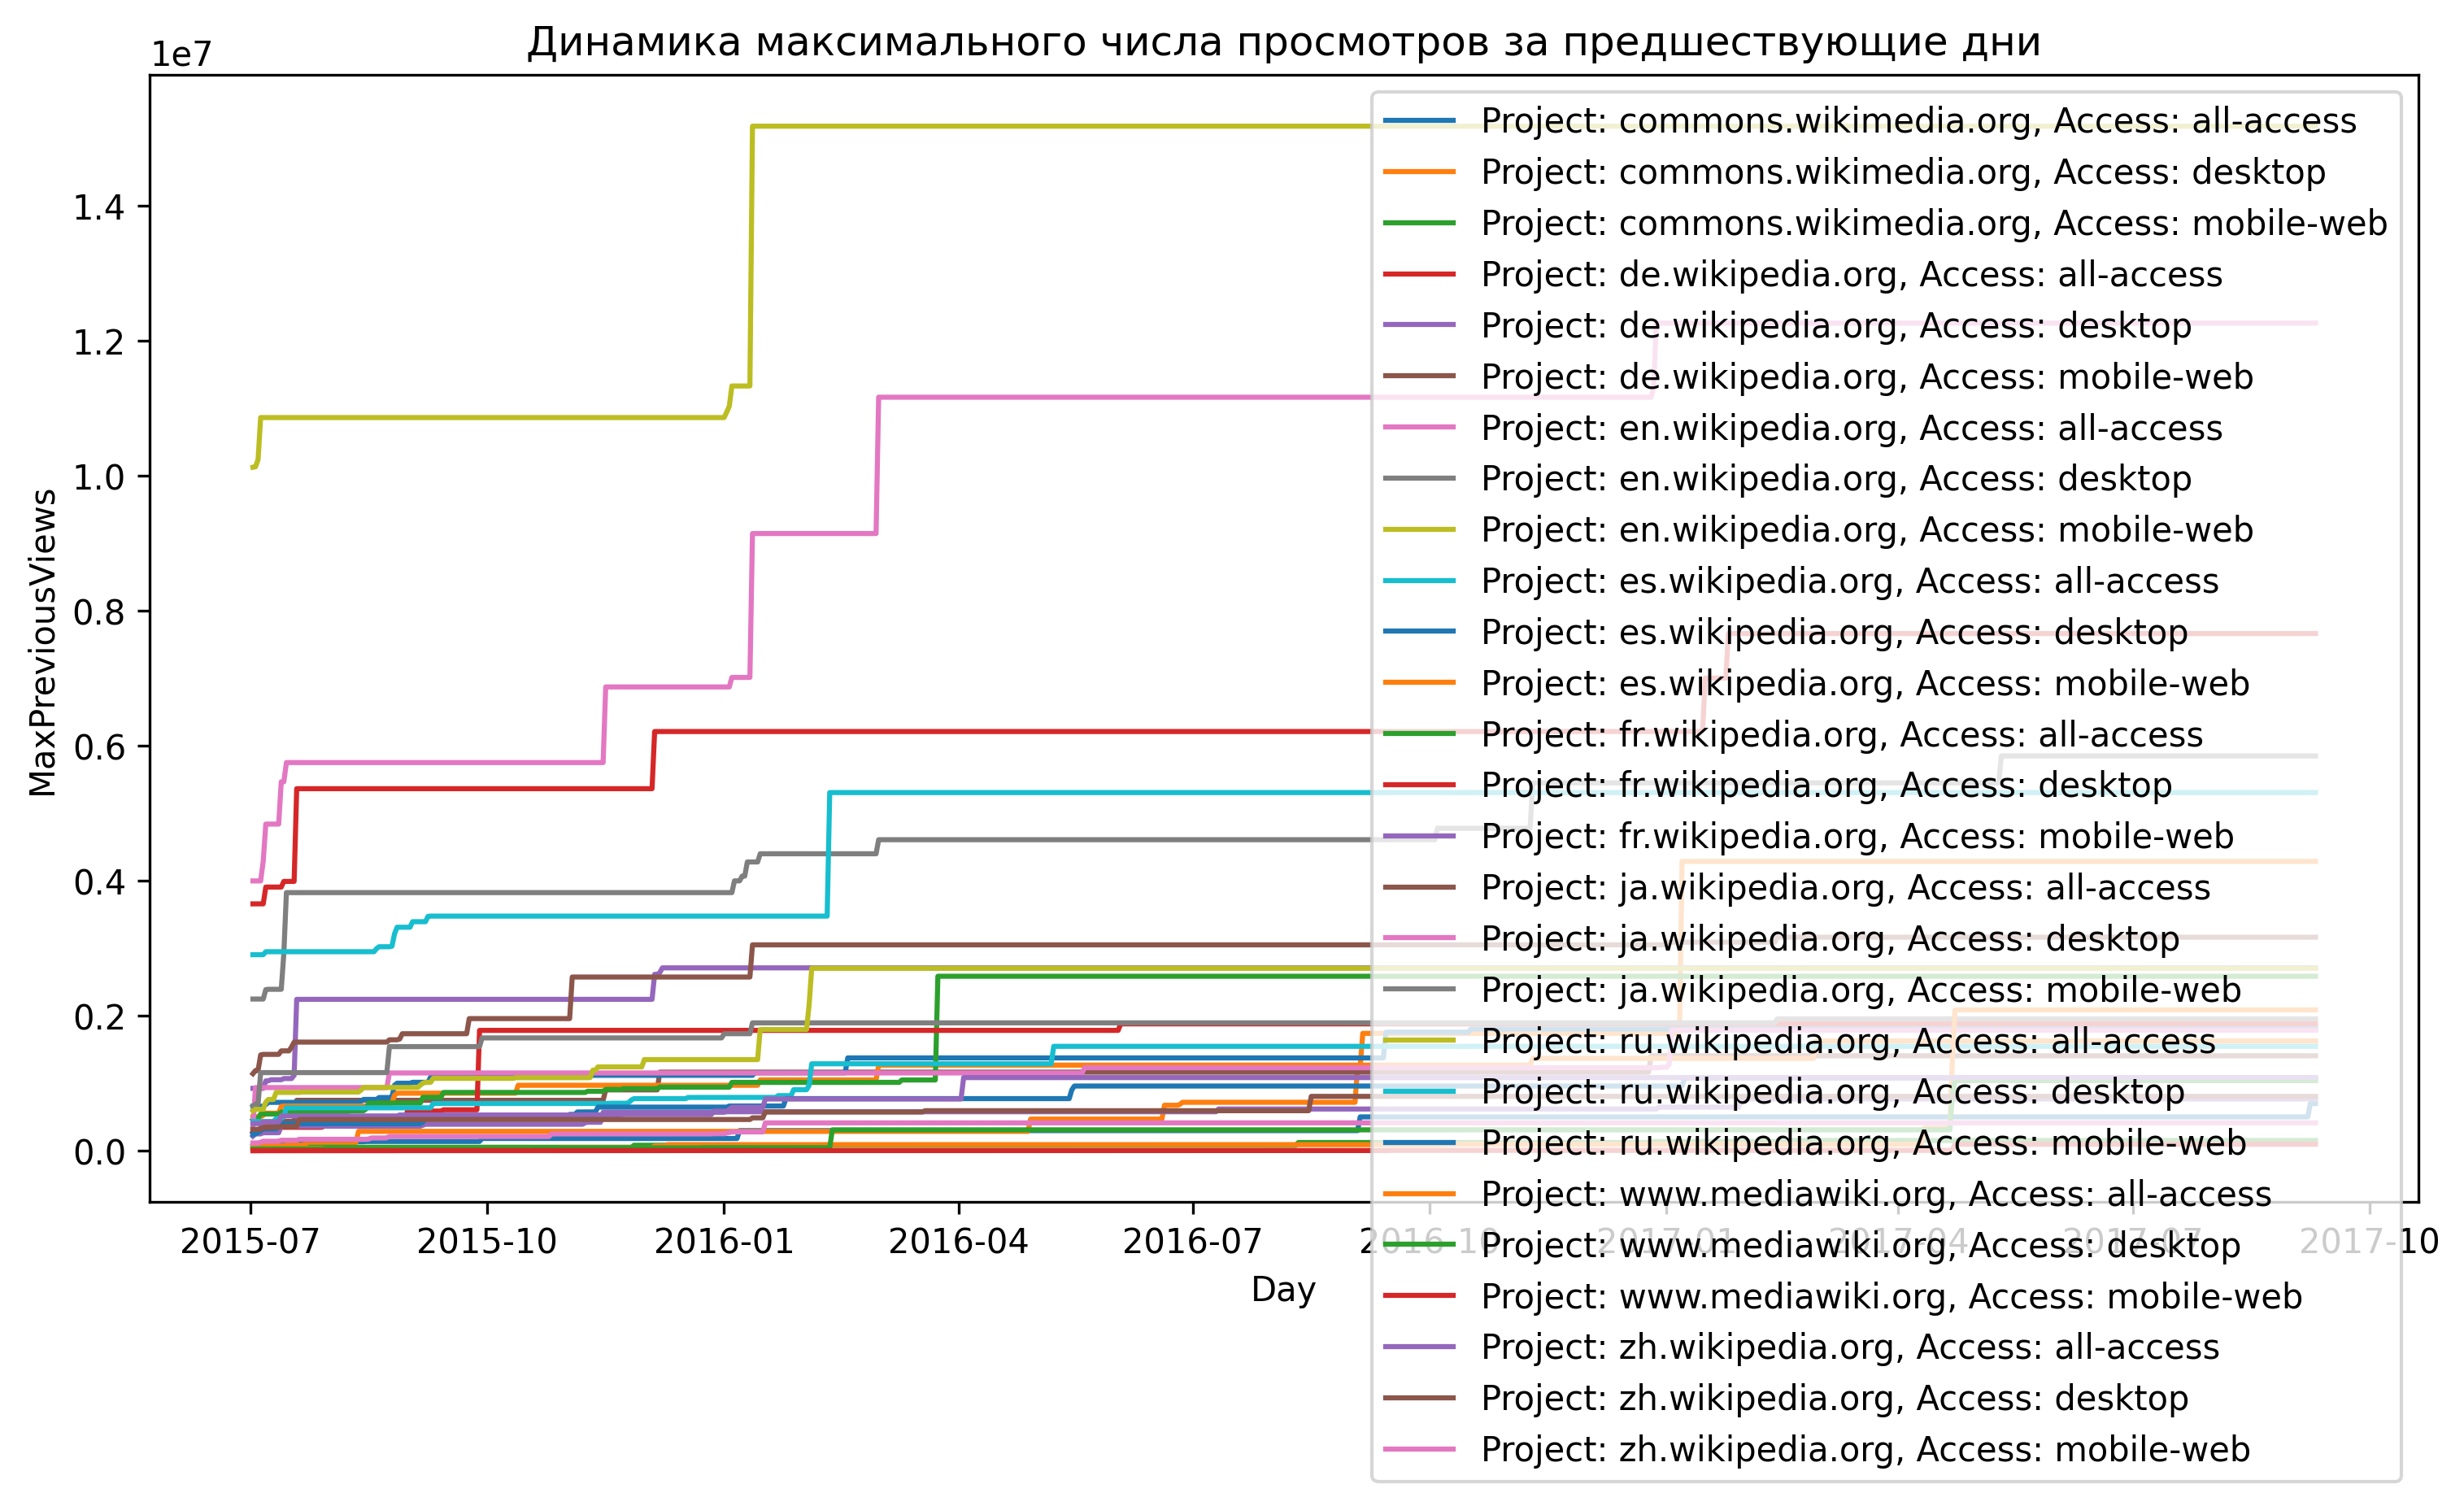

In [16]:
# YOUR CODE HERE
w = Window.partitionBy("Project", "Access").orderBy("Day")
art_maxv = ( art_maxv.withColumn("Day", F.col("Day").cast("date"))
                     .withColumn("MaxPreviousViews", F.col("MaxPreviousViews").cast("int"))
           )
art_maxv = art_maxv.withColumn("MaxPreviousViews", F.max("MaxPreviousViews").over(w))

pandas_df = art_maxv.toPandas()

# Построение графика
plt.figure(figsize=(12, 6))
for (project, access), group in pandas_df.groupby(["Project", "Access"]):
    plt.plot(group["Day"], group["MaxPreviousViews"], label=f"Project: {project}, Access: {access}")

plt.xlabel("Day")
plt.ylabel("MaxPreviousViews")
plt.title("Динамика максимального числа просмотров за предшествующие дни")
plt.legend()
plt.show()

**Задание 08:** Рассмотрим задачу предсказания числа просмотров конкретной страницы на следующий день. Рассмотрим два простейших варианта предсказания:
* Среднее за $7$ предыдущих дней
* Лаг с шагом $1$ — значение за предыдущий день

Создайте две колонки, которые будут содержать указанные варианты предсказания числа просмотров.

*Замечание:* Если предсказание не определено, то используйте среднее число просмотров страницы.

*Подсказка:* Вам могут пригодиться функции `cast`, `coalesce`.

In [17]:
### YOUR CODE HERE:
w = Window.partitionBy('Page').orderBy(F.col('Day').cast('timestamp').cast('long'))
df_pred  = df_unpivot.withColumn('Prev_7_days_avg', F.avg('Views').over(w.rangeBetween(-days(7), 0)))
df_pred = df_pred.withColumn('Prev_day_views', F.lag('Views', 1).over(w))
df_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

# заполним NULL значения средними значения по странице
mean_views_per_page = df_pred.groupBy('Page').agg(F.avg('Views').alias('Mean_Page_Views'))
df_pred = df_pred.join(mean_views_per_page, on='Page', how='left')
df_pred = df_pred.withColumn('Prev_7_days_avg', F.coalesce('Prev_7_days_avg', 'Mean_Page_Views'))
df_pred = df_pred.withColumn('Prev_day_views', F.coalesce('Prev_day_views', 'Mean_Page_Views'))

# YOUR CODE HERE
df_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

+--------------------+----------+------+------------------+------------------+--------------+
|                Page|       Day| Views|        Mean Views|   Prev_7_days_avg|Prev_day_views|
+--------------------+----------+------+------------------+------------------+--------------+
|Idioma_español_es...|2015-07-01|1321.0|            1321.0|            1321.0|          NULL|
|Idioma_español_es...|2015-07-02|1218.0|            1269.5|            1269.5|        1321.0|
|Idioma_español_es...|2015-07-03|1129.0|1222.6666666666667|1222.6666666666667|        1218.0|
|Idioma_español_es...|2015-07-04|1187.0|           1213.75|           1213.75|        1129.0|
|Idioma_español_es...|2015-07-05|1325.0|            1236.0|            1236.0|        1187.0|
|Idioma_español_es...|2015-07-06|1319.0|1249.8333333333333|1249.8333333333333|        1325.0|
|Idioma_español_es...|2015-07-07|1356.0|            1265.0|            1265.0|        1319.0|
|Idioma_español_es...|2015-07-08|1402.0|          1282.125| 

+--------------------+----------+------+------------------+------------------+------------------+------------------+
|                Page|       Day| Views|        Mean Views|   Prev_7_days_avg|    Prev_day_views|   Mean_Page_Views|
+--------------------+----------+------+------------------+------------------+------------------+------------------+
|Idioma_español_es...|2015-07-01|1321.0|            1321.0|            1321.0|2191.7658779576586|2191.7658779576586|
|Idioma_español_es...|2015-07-02|1218.0|            1269.5|            1269.5|            1321.0|2191.7658779576586|
|Idioma_español_es...|2015-07-03|1129.0|1222.6666666666667|1222.6666666666667|            1218.0|2191.7658779576586|
|Idioma_español_es...|2015-07-04|1187.0|           1213.75|           1213.75|            1129.0|2191.7658779576586|
|Idioma_español_es...|2015-07-05|1325.0|            1236.0|            1236.0|            1187.0|2191.7658779576586|
|Idioma_español_es...|2015-07-06|1319.0|1249.8333333333333|1249.

**Задание 09:** Оценим пролучившиеся модели. Для этого посчитаем метрику качества **SMAPE**:

$$
\text{SMAPE} = \frac{200\%}{n} \sum\limits_{i=1}^{n} \frac{|y_{i} - \hat{y}_{i}|}{|y_{i}| + |\hat{y}_{i}|}
$$

Где $y_{i}$, $\hat{y}_{i}$ — истинный ответ (таргет) и предсказание модели соответственно.

Подроднее прочитать про [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) и [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) можно на Википедии, а также у [А.Г. Дьяконова](https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf).

Для удобства реализуем подсчёт метрики в виде отдельной функции.

In [18]:
def count_smape(
    df: pyspark.sql.dataframe.DataFrame, 
    target_col: str, prediction_col: str,
    groups: Optional[List[str]]=None
) -> pyspark.sql.dataframe.DataFrame:
    '''
     :param pyspark.sql.dataframe.DataFrame df: Датафрейм для которого считается SMAPE
     :param str target_col: Название колонки в которой находятся истинные значения целевой переменной
     :param str prediction_col: Название колонки в которой находятся предсказания
     :param Optional[List[str]] groups: Список колонок по которым нужно выполнить агрегацию
         значений метрики для отдельных объектов выборки. Если `groups is None` нужно вернуть 
         среднее по всей выборке
     :return pyspark.sql.dataframe.DataFrame: 
    '''
    ### YOUR CODE HERE:
    smape = 200  * F.sum(F.abs(F.col(target_col) - F.col(prediction_col)) / (F.abs(F.col(target_col)) + F.abs(F.col(prediction_col))))
    if groups is not None:
        smape = df.groupBy(*groups).agg((1 / F.count('*') * smape).alias("SMAPE"))
    else:
        smape = (1 / df.count()) * smape
        smape = df.agg(smape.alias("SMAPE"))
        
    return smape


In [19]:
# SHOW SMAPE FOR LAG PREDICTION
count_smape(df_pred, 'Views', 'Prev_day_views').show()
# SHOW SMAPE FOR MEAN PREDICTION
count_smape(df_pred, 'Views', 'Prev_7_days_avg').show()

+-----------------+
|            SMAPE|
+-----------------+
|33.91722688013275|
+-----------------+



+------------------+
|             SMAPE|
+------------------+
|31.205731819486424|
+------------------+



In [20]:
# создадим unpivot из articles с колонками Page и Project
art_unpivot = articles.unpivot(['Page', 'Project'], cols, 'Day', 'Views' )
art_unpivot.show()

+--------------------+----------------+----------+-----+
|                Page|         Project|       Day|Views|
+--------------------+----------------+----------+-----+
|Idioma_español_es...|es.wikipedia.org|2015-07-01| 99.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-02|116.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-03| 70.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-04| 63.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-05| 59.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-06| 79.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-07| 54.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-08| 83.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-09| 72.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-10| 77.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-11| 78.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-12| 77.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-13|138.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-14|128.0|
|Idioma_español_es...|es.wikipe

In [21]:
# расчитаем предсказания
### YOUR CODE HERE:
w = Window.partitionBy('Page').orderBy(F.col('Day').cast('timestamp').cast('long'))
df_art_pred  = art_unpivot.withColumn('Prev_7_days_avg', F.avg('Views').over(w.rangeBetween(-days(7), 0)))
df_art_pred = df_art_pred.withColumn('Prev_day_views', F.lag('Views', 1).over(w))
df_art_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

# заполним NULL значения средними значения по странице
mean_views_per_page = df_art_pred.groupBy('Page').agg(F.avg('Views').alias('Mean_Page_Views'))
df_art_pred = df_art_pred.join(mean_views_per_page, on='Page', how='left')
df_art_pred = df_art_pred.withColumn('Prev_7_days_avg', F.coalesce('Prev_7_days_avg', 'Mean_Page_Views'))
df_art_pred = df_art_pred.withColumn('Prev_day_views', F.coalesce('Prev_day_views', 'Mean_Page_Views'))

# YOUR CODE HERE
df_art_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

+--------------------+----------------+----------+-----+-----------------+--------------+
|                Page|         Project|       Day|Views|  Prev_7_days_avg|Prev_day_views|
+--------------------+----------------+----------+-----+-----------------+--------------+
|Idioma_español_es...|es.wikipedia.org|2015-07-01| 99.0|             99.0|          NULL|
|Idioma_español_es...|es.wikipedia.org|2015-07-02|116.0|            107.5|          99.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-03| 70.0|             95.0|         116.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-04| 63.0|             87.0|          70.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-05| 59.0|             81.4|          63.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-06| 79.0|             81.0|          59.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-07| 54.0|77.14285714285714|          79.0|
|Idioma_español_es...|es.wikipedia.org|2015-07-08| 83.0|           77.875|          54.0|
|Idioma_es

+--------------------+----------------+----------+-----+-----------------+-----------------+-----------------+
|                Page|         Project|       Day|Views|  Prev_7_days_avg|   Prev_day_views|  Mean_Page_Views|
+--------------------+----------------+----------+-----+-----------------+-----------------+-----------------+
|Idioma_español_es...|es.wikipedia.org|2015-07-01| 99.0|             99.0|158.4931506849315|158.4931506849315|
|Idioma_español_es...|es.wikipedia.org|2015-07-02|116.0|            107.5|             99.0|158.4931506849315|
|Idioma_español_es...|es.wikipedia.org|2015-07-03| 70.0|             95.0|            116.0|158.4931506849315|
|Idioma_español_es...|es.wikipedia.org|2015-07-04| 63.0|             87.0|             70.0|158.4931506849315|
|Idioma_español_es...|es.wikipedia.org|2015-07-05| 59.0|             81.4|             63.0|158.4931506849315|
|Idioma_español_es...|es.wikipedia.org|2015-07-06| 79.0|             81.0|             59.0|158.4931506849315|
|

In [22]:
# найдем SMAPE в разрезе Project
# SHOW LAG SMAPE TABLE
count_smape(df_art_pred, 'Views', 'Prev_day_views', groups=['Project']).show(truncate=False)

# SHOW MEAN SMAPE TABLE
count_smape(df_art_pred, 'Views', 'Prev_7_days_avg', groups=['Project']).show(truncate=False)

+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|46.97935786650056 |
|en.wikipedia.org     |31.02598761471754 |
|www.mediawiki.org    |53.0384659452727  |
|de.wikipedia.org     |35.71770301448071 |
|es.wikipedia.org     |31.913091237024666|
|ja.wikipedia.org     |30.48972638807652 |
|ru.wikipedia.org     |26.1731372495232  |
|zh.wikipedia.org     |30.78645128157113 |
|fr.wikipedia.org     |35.10201389622772 |
+---------------------+------------------+



+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|51.76153871232846 |
|en.wikipedia.org     |27.936481418861174|
|www.mediawiki.org    |47.77155241915149 |
|de.wikipedia.org     |31.36628384567278 |
|es.wikipedia.org     |28.846647610507546|
|ja.wikipedia.org     |28.68878833149231 |
|ru.wikipedia.org     |24.143153093439423|
|zh.wikipedia.org     |26.92896568680069 |
|fr.wikipedia.org     |30.78902645426884 |
+---------------------+------------------+



**Задание 10:** Определите, какая из двух моделей работает лучше. Одинаковый ли результат получается для разных Project? А для Agent/Access?

In [23]:
# построим unpivot с колонками Page, Agent, Access
art_unpivot = articles.unpivot(['Page', 'Agent', 'Access'], cols, 'Day', 'Views' )
art_unpivot.show()

+--------------------+------+----------+----------+-----+
|                Page| Agent|    Access|       Day|Views|
+--------------------+------+----------+----------+-----+
|Idioma_español_es...|spider|all-access|2015-07-01| 99.0|
|Idioma_español_es...|spider|all-access|2015-07-02|116.0|
|Idioma_español_es...|spider|all-access|2015-07-03| 70.0|
|Idioma_español_es...|spider|all-access|2015-07-04| 63.0|
|Idioma_español_es...|spider|all-access|2015-07-05| 59.0|
|Idioma_español_es...|spider|all-access|2015-07-06| 79.0|
|Idioma_español_es...|spider|all-access|2015-07-07| 54.0|
|Idioma_español_es...|spider|all-access|2015-07-08| 83.0|
|Idioma_español_es...|spider|all-access|2015-07-09| 72.0|
|Idioma_español_es...|spider|all-access|2015-07-10| 77.0|
|Idioma_español_es...|spider|all-access|2015-07-11| 78.0|
|Idioma_español_es...|spider|all-access|2015-07-12| 77.0|
|Idioma_español_es...|spider|all-access|2015-07-13|138.0|
|Idioma_español_es...|spider|all-access|2015-07-14|128.0|
|Idioma_españo

In [24]:
# найдем предсказания
### YOUR CODE HERE:
w = Window.partitionBy('Page').orderBy(F.col('Day').cast('timestamp').cast('long'))
df_art_pred  = art_unpivot.withColumn('Prev_7_days_avg', F.avg('Views').over(w.rangeBetween(-days(7), 0)))
df_art_pred = df_art_pred.withColumn('Prev_day_views', F.lag('Views', 1).over(w))
df_art_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

# заполним NULL значения средними значения по странице
mean_views_per_page = df_art_pred.groupBy('Page').agg(F.avg('Views').alias('Mean_Page_Views'))
df_art_pred = df_art_pred.join(mean_views_per_page, on='Page', how='left')
df_art_pred = df_art_pred.withColumn('Prev_7_days_avg', F.coalesce('Prev_7_days_avg', 'Mean_Page_Views'))
df_art_pred = df_art_pred.withColumn('Prev_day_views', F.coalesce('Prev_day_views', 'Mean_Page_Views'))

# YOUR CODE HERE
df_art_pred.where(F.col('Page').like('Idioma_español_es%')).show(10)

+--------------------+------+----------+----------+-----+-----------------+--------------+
|                Page| Agent|    Access|       Day|Views|  Prev_7_days_avg|Prev_day_views|
+--------------------+------+----------+----------+-----+-----------------+--------------+
|Idioma_español_es...|spider|all-access|2015-07-01| 99.0|             99.0|          NULL|
|Idioma_español_es...|spider|all-access|2015-07-02|116.0|            107.5|          99.0|
|Idioma_español_es...|spider|all-access|2015-07-03| 70.0|             95.0|         116.0|
|Idioma_español_es...|spider|all-access|2015-07-04| 63.0|             87.0|          70.0|
|Idioma_español_es...|spider|all-access|2015-07-05| 59.0|             81.4|          63.0|
|Idioma_español_es...|spider|all-access|2015-07-06| 79.0|             81.0|          59.0|
|Idioma_español_es...|spider|all-access|2015-07-07| 54.0|77.14285714285714|          79.0|
|Idioma_español_es...|spider|all-access|2015-07-08| 83.0|           77.875|          54.0|

+--------------------+------+----------+----------+-----+-----------------+-----------------+-----------------+
|                Page| Agent|    Access|       Day|Views|  Prev_7_days_avg|   Prev_day_views|  Mean_Page_Views|
+--------------------+------+----------+----------+-----+-----------------+-----------------+-----------------+
|Idioma_español_es...|spider|all-access|2015-07-01| 99.0|             99.0|158.4931506849315|158.4931506849315|
|Idioma_español_es...|spider|all-access|2015-07-02|116.0|            107.5|             99.0|158.4931506849315|
|Idioma_español_es...|spider|all-access|2015-07-03| 70.0|             95.0|            116.0|158.4931506849315|
|Idioma_español_es...|spider|all-access|2015-07-04| 63.0|             87.0|             70.0|158.4931506849315|
|Idioma_español_es...|spider|all-access|2015-07-05| 59.0|             81.4|             63.0|158.4931506849315|
|Idioma_español_es...|spider|all-access|2015-07-06| 79.0|             81.0|             59.0|158.4931506

In [25]:
# найдем SMAPE в разрезе Agent/Access
### YOUR CODE HERE:

# SHOW SMAPE LAG 
count_smape(df_art_pred, 'Views', 'Prev_day_views', groups=['Agent', 'Access']).show(truncate=False)
# SHOW SMAPE MEAN
count_smape(df_art_pred, 'Views', 'Prev_7_days_avg', groups=['Agent', 'Access']).show(truncate=False)

+----------+----------+------------------+
|Agent     |Access    |SMAPE             |
+----------+----------+------------------+
|all-agents|mobile-web|30.75401041341402 |
|spider    |all-access|51.50663992242175 |
|all-agents|all-access|28.025505905021816|
|all-agents|desktop   |25.996651298098854|
+----------+----------+------------------+



+----------+----------+------------------+
|Agent     |Access    |SMAPE             |
+----------+----------+------------------+
|all-agents|mobile-web|31.26742972293278 |
|spider    |all-access|42.530917731501724|
|all-agents|all-access|26.402484363188368|
|all-agents|desktop   |25.03560135418675 |
+----------+----------+------------------+



**Ответ:**

### Модель "прогноз по предыдущему дню" (Prev_day_views)
 - в целом качество SMAPE $\approx$ 33.91       
 - лучшее качество SMAPE $\approx$ 26.17 получилось для проекта `ru.wikipedia.org`
 - худшее для проекта `www.mediawiki.org`   (SMAPE $\approx$ 53.03)
 - лучшее качество SMAPE $\approx$ 25.99 по группе agent/access получилось для `all-agents|desktop`
 - худшее для `spider|all-access`  (SMAPE $\approx$ 51.50)

### Модель "среднее за неделю" (Prev_7_days_avg)
 - в целом качество SMAPE $\approx$ 31.2
 - лучшее качество SMAPE $\approx$ 24.14 получилось для проекта `ru.wikipedia.org`
 - худшее для проекта `commons.wikimedia.org`   (SMAPE $\approx$  51.76)
 - лучшее качество SMAPE $\approx$ 25.03 по группе agent/access получилось для `all-agents|desktop`
 - худшее для `spider|all-access` SMAPE $\approx$ 42.53

Видно, что как в целом модель  `Prev_7_days_avg` демонстрирует чуть лучшее качество SMAPE, чем  `Prev_day_views` (SMAPE 31.2 против 33.91) так и по отдельным проектам и группам agent/access. Вопрос насколько это статистически значимо требует отдельного исследования.